# Flow matching matches marginal (not joint) distribution at every time step within trajectory chunk

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch; torch.set_default_dtype(torch.double)
from streaming_flow_policy.all import StreamingFlowPolicyLatent
from streaming_flow_policy.toy.plot_latent import (
    plot_probability_density_a,
    plot_probability_density_z,
    plot_probability_density_with_static_trajectories,
)

from pydrake.all import (
    PiecewisePolynomial,
    Trajectory,
)

# Set seed
np.random.seed(0)

## Set hyperparameters

In [2]:
σ0 = 0.001
σ1 = 0.05

In [3]:
def demonstration_traj_right() -> Trajectory:
    return PiecewisePolynomial.CubicWithContinuousSecondDerivatives(
        breaks=[0.00, 0.25, 0.50, 0.75, 1.0],
        samples=[[0.00, 0.75, 0.00, -0.75, 0.00]],
        sample_dot_at_start=[[3.0]],
        sample_dot_at_end=[[3.0]],
    )

def demonstration_traj_left() -> Trajectory:
    return PiecewisePolynomial.CubicWithContinuousSecondDerivatives(
        breaks=[0.00, 0.25, 0.50, 0.75, 1.0],
        samples=[[0.00, -0.75, 0.00, 0.75, 0.00]],
        sample_dot_at_start=[[-3.0]],
        sample_dot_at_end=[[-3.0]],
    )

traj_right = demonstration_traj_right()
traj_left = demonstration_traj_left()

## Plot demonstration trajectories

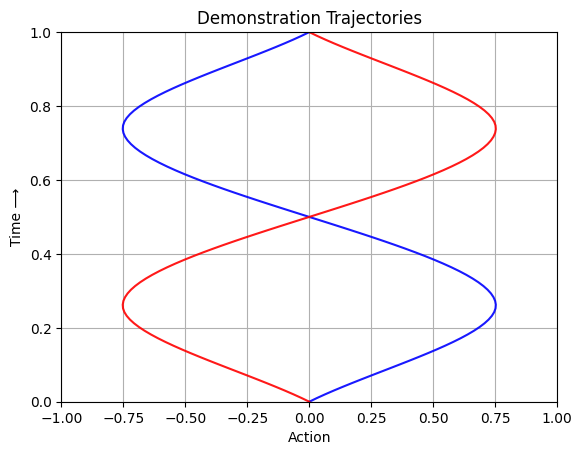

In [4]:
"""
Plot demonstration trajectory on x-y plane where x axis is the state in [-1, 1]
and y axis is the time in [0, 1].
"""
times = np.linspace(0, 1, 100)
plt.plot(traj_right.vector_values(times)[0], times, color='blue', alpha=0.9)
plt.plot(traj_left.vector_values(times)[0], times, color='red', alpha=0.9)
plt.xlim(-1, 1)
plt.ylim(0, 1)
plt.xlabel('Action')
plt.ylabel('Time ⟶')
plt.title('Demonstration Trajectories')
plt.grid(True)
plt.show()

## Conditional flow

In [5]:
fp = StreamingFlowPolicyLatent(dim=1, trajectories=[traj_right], prior=[1.0], σ0=σ0, σ1=σ1)

## Plot conditional probability path of right trajectory

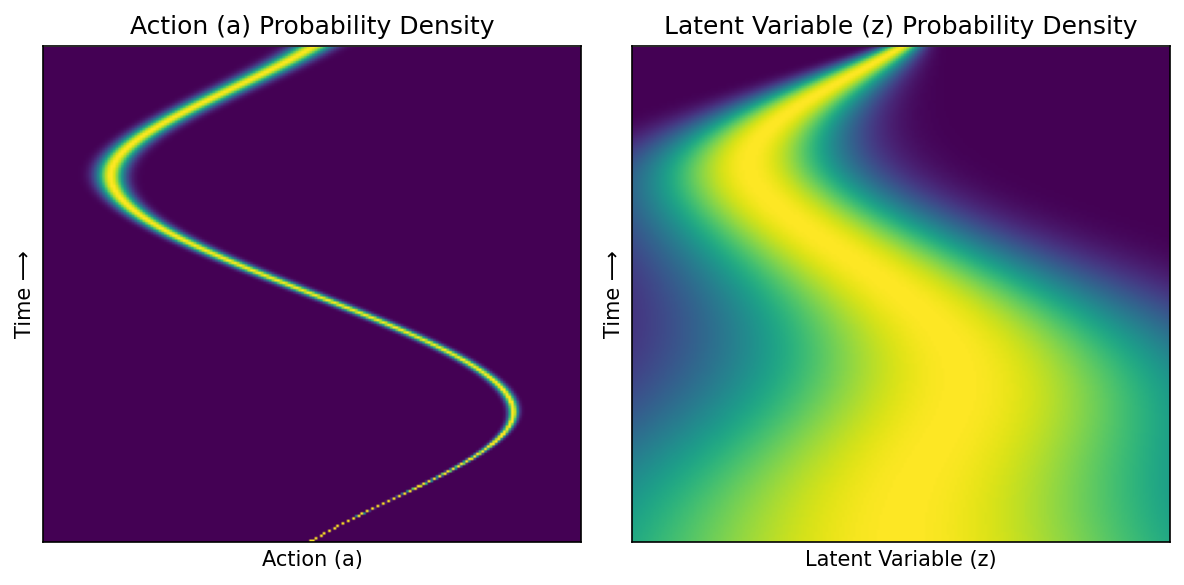

In [6]:
fig = plt.figure(figsize=(8, 4), dpi=150)

xs = torch.linspace(-1, 1, 200)
ts = torch.linspace(0, 1, 200)
ts, xs = torch.meshgrid(ts, xs, indexing='ij')  # (T, X)

gs = fig.add_gridspec(1, 2, width_ratios=[1, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

plot_probability_density_a(fp, ts, xs, ax1)
plot_probability_density_z(fp, ts, xs, ax2)

ax1.set_title('Action (a) Probability Density', size='large')
ax2.set_title('Latent Variable (z) Probability Density', size='large')

ax1.set_xlabel('Action (a)')
ax1.set_ylabel('Time ⟶')
ax2.set_xlabel('Latent Variable (z)')
ax2.set_ylabel('Time ⟶')

plt.tight_layout()
plt.show()

## Plot trajectories under conditional flow of right trajectory

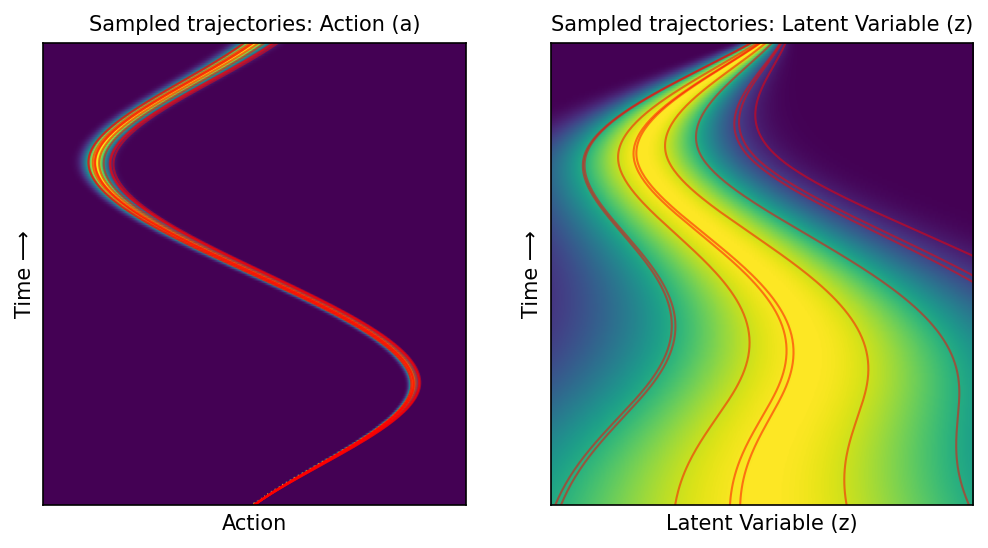

In [7]:
a_starts = [0.0] * 10
z_starts_pos = np.abs(np.random.randn(5))
z_starts_neg = -np.abs(np.random.randn(5))
z_starts = sorted(np.concatenate([z_starts_neg, z_starts_pos]))
colors = ['red'] * 5 + ['red'] * 5

fig = plt.figure(figsize=(8, 4), dpi=150)

gs = fig.add_gridspec(1, 2, width_ratios=[1, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

plot_probability_density_with_static_trajectories(
    fp, ax1, ax2, a_starts, z_starts, colors, num_points_x=400,
)
plt.show()


## Marginal flow

In [8]:
fp = StreamingFlowPolicyLatent(dim=1, trajectories=[traj_right, traj_left], prior=[0.5, 0.5], σ0=σ0, σ1=σ1)

## Plot marginal probability path

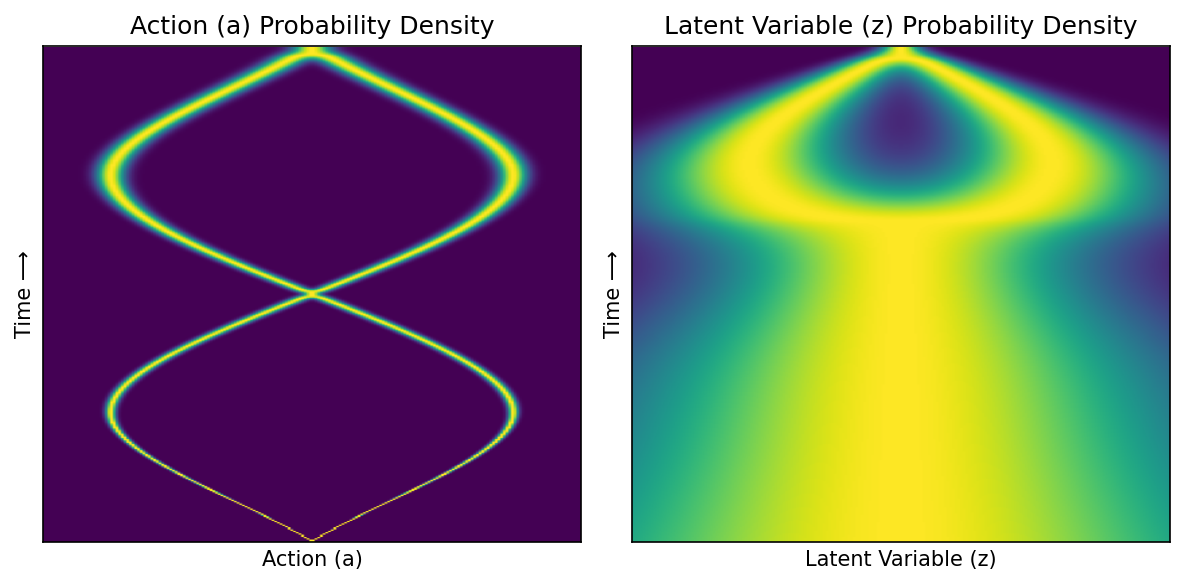

In [9]:
fig = plt.figure(figsize=(8, 4), dpi=150)

xs = torch.linspace(-1, 1, 200)
ts = torch.linspace(0, 1, 400)
ts, xs = torch.meshgrid(ts, xs, indexing='ij')  # (T, X)

gs = fig.add_gridspec(1, 2, width_ratios=[1, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

plot_probability_density_a(fp, ts, xs, ax1)
plot_probability_density_z(fp, ts, xs, ax2)

ax1.set_title('Action (a) Probability Density', size='large')
ax2.set_title('Latent Variable (z) Probability Density', size='large')

ax1.set_xlabel('Action (a)')
ax1.set_ylabel('Time ⟶')
ax2.set_xlabel('Latent Variable (z)')
ax2.set_ylabel('Time ⟶')

plt.tight_layout()
plt.show()

## Plot trajectories under marginal flow

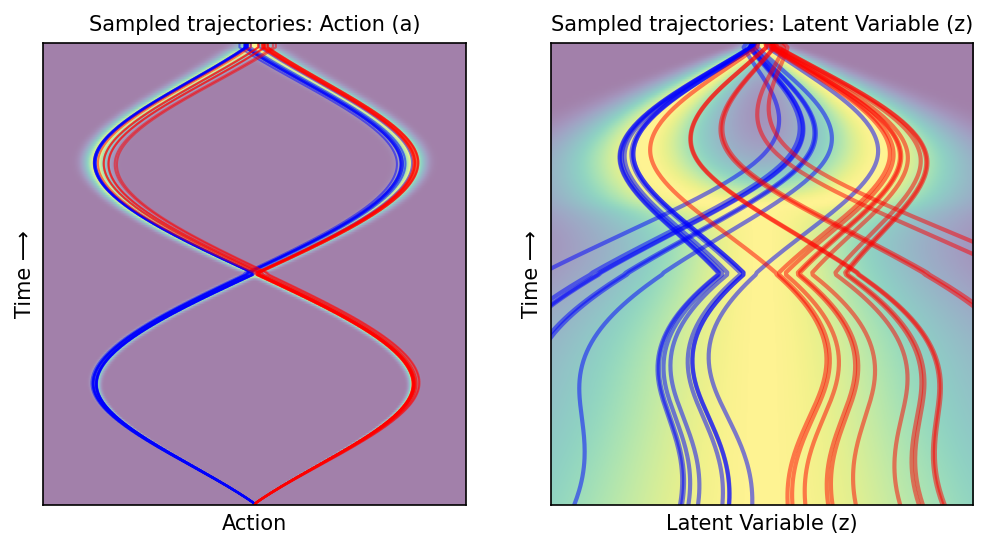

In [10]:
a_starts = [0.0] * 30
z_starts_pos = np.abs(np.random.randn(15))
z_starts_neg = -np.abs(np.random.randn(15))
z_starts = sorted(np.concatenate([z_starts_pos, z_starts_neg]))
colors = ['blue'] * 15 + ['red'] * 15

fig = plt.figure(figsize=(8, 4), dpi=150)

gs = fig.add_gridspec(1, 2, width_ratios=[1, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

plot_probability_density_with_static_trajectories(
    fp, ax1, ax2, a_starts, z_starts, colors,
    heatmap_alpha=0.5,
    linewidth_a=1, linewidth_z=2,
    num_points_x=400,
    ode_steps=10000,
)
plt.show()